In [8]:
# Upload google drive in our COLAB

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Download HSI Data
!wget http://www.ehu.eus/ccwintco/uploads/e/ee/PaviaU.mat http://www.ehu.eus/ccwintco/uploads/5/50/PaviaU_gt.mat

--2023-03-27 21:55:39--  http://www.ehu.eus/ccwintco/uploads/e/ee/PaviaU.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.ehu.eus/ccwintco/uploads/e/ee/PaviaU.mat [following]
--2023-03-27 21:55:39--  https://www.ehu.eus/ccwintco/uploads/e/ee/PaviaU.mat
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34806917 (33M)
Saving to: ‘PaviaU.mat’

PaviaU.mat          100%[===================>]  33.19M  2.12MB/s    in 15s     

2023-03-27 21:55:55 (2.15 MB/s) - ‘PaviaU.mat’ saved [34806917/34806917]

URL transformed to HTTPS due to an HSTS policy
--2023-03-27 21:55:55--  https://www.ehu.eus/ccwintco/uploads/5/50/PaviaU_gt.mat
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:443... connected.
HTTP request sent, awaiting response... 200 

In [ ]:
!ls

PaviaU_gt.mat  PaviaU.mat  sample_data


In [35]:
from sklearn.model_selection import train_test_split
import numpy as np
from scipy.io import loadmat
# Load hyperspectral data and labels
X =loadmat('PaviaU.mat')['paviaU']
y=loadmat('PaviaU_gt.mat')['paviaU_gt']
print(f'Data Shape: {X.shape[:-1]}\nNumber of Bands: {y.shape[-1]}')

Data Shape: (610, 340)
Number of Bands: 340


In [41]:
X = X.reshape(-1, X.shape[2])

In [44]:
y = np.reshape(y, (-1))
y.shape

(207400,)

In [ ]:
from sklearn.svm import SVC
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=11, stratify=y)
svm = SVC(C = 100, kernel ='rbf', cache_size = 10*1024)
svm.fit(X_train, y_train)
ypred = svm.predict(X_test)

In [46]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test,ypred)
print("SVM accuracy:",acc)

SVM accuracy: 0.834450337512054


In [47]:
from sklearn.metrics import classification_report
print('Classification report:\n', classification_report(y_test,ypred,zero_division=0))

Classification report:
               precision    recall  f1-score   support

           0       0.85      0.97      0.90     32925
           1       0.00      0.00      0.00      1326
           2       0.71      0.61      0.65      3730
           3       0.86      0.01      0.03       420
           4       0.75      0.10      0.18       613
           5       0.82      0.91      0.86       269
           6       1.00      0.00      0.01      1006
           7       0.67      0.62      0.64       266
           8       0.67      0.01      0.03       736
           9       0.00      0.00      0.00       189

    accuracy                           0.83     41480
   macro avg       0.63      0.32      0.33     41480
weighted avg       0.80      0.83      0.79     41480



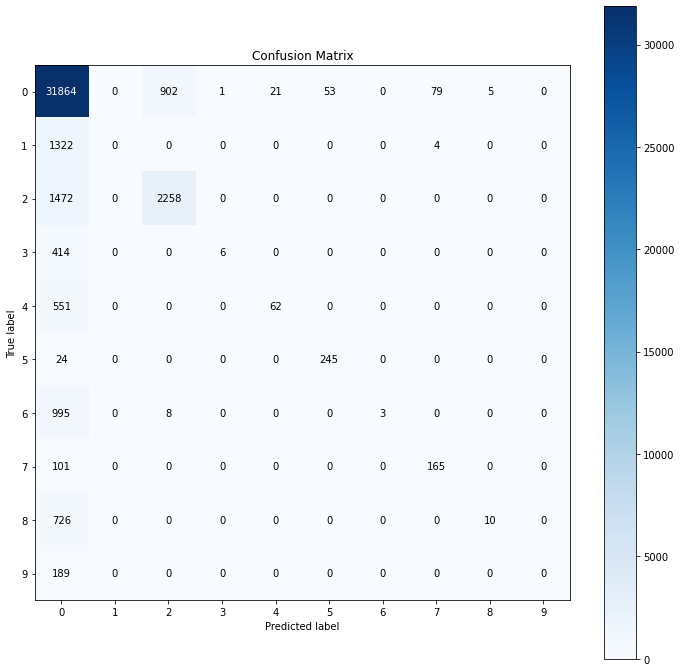

In [48]:
from sklearn.metrics import confusion_matrix
! pip install -q scikit-plot
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(
    y_test, 
    ypred,
    figsize=(12,12));